In [ ]:
!pip install shap
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import scipy.io
import h5py
import tensorflow as tf
import shap
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython.display import clear_output


In [ ]:

def _shap_div_no_nan(op, grad):
    x, y = op.inputs
    not_zero = tf.greater(tf.abs(y), 1e-12)
    not_inf = tf.logical_not(tf.logical_or(tf.is_inf(y), tf.is_inf(grad)))
    valid = tf.logical_and(not_zero, not_inf)
    return tf.where(valid, grad / y, tf.zeros_like(grad))

# Register the gradient function with Keras
K.__dict__["gradients"] = _shap_div_no_nan

**Loading the data and creating pickle file using only one batch**


In [ ]:
def load_data(file_name,pickle_name):
  f = h5py.File(file_name,"r")
  print(list(f.keys()))
  batch=f.get("batch")
  num_cells = batch['summary'].shape[0]
  bat_dict = {}
  for i in range(num_cells):
    cl = f[batch['cycle_life'][i,0]][()] #ici on a remplacé ".value" par "[()]", et dans toutes les lignes suivantes
    policy = f[batch['policy_readable'][i,0]][()].tobytes()[::2].decode()
    summary_IR = np.hstack(f[batch['summary'][i,0]]['IR'][0,:].tolist())
    summary_QC = np.hstack(f[batch['summary'][i,0]]['QCharge'][0,:].tolist())
    summary_QD = np.hstack(f[batch['summary'][i,0]]['QDischarge'][0,:].tolist())
    summary_TA = np.hstack(f[batch['summary'][i,0]]['Tavg'][0,:].tolist())
    summary_TM = np.hstack(f[batch['summary'][i,0]]['Tmin'][0,:].tolist())
    summary_TX = np.hstack(f[batch['summary'][i,0]]['Tmax'][0,:].tolist())
    summary_CT = np.hstack(f[batch['summary'][i,0]]['chargetime'][0,:].tolist())
    summary_CY = np.hstack(f[batch['summary'][i,0]]['cycle'][0,:].tolist())
    summary = ({'IR': summary_IR, #création d'un 1er dict avec les données "résumées", càd 1 donnée par cycle
               'QC': summary_QC, 
               'QD': summary_QD, 
               'Tavg': summary_TA, 
               'Tmin': summary_TM, 
               'Tmax': summary_TX, 
               'chargetime': summary_CT,
               'cycle': summary_CY}) 
    cycles = f[batch['cycles'][i,0]]
    cycle_dict = {}
    for j in range(cycles['I'].shape[0]):
        I = np.hstack((f[cycles['I'][j,0]][()]))
        Qc = np.hstack((f[cycles['Qc'][j,0]][()]))
        Qd = np.hstack((f[cycles['Qd'][j,0]][()]))
        Qdlin = np.hstack((f[cycles['Qdlin'][j,0]][()]))
        T = np.hstack((f[cycles['T'][j,0]][()]))
        Tdlin = np.hstack((f[cycles['Tdlin'][j,0]][()]))
        V = np.hstack((f[cycles['V'][j,0]][()]))
        dQdV = np.hstack((f[cycles['discharge_dQdV'][j,0]][()]))
        t = np.hstack((f[cycles['t'][j,0]][()]))
        cd = ({'I': I,   #création d'un 2è dictionnnaire pour les données temporelles
               'Qc': Qc, 
               'Qd': Qd, 
               'Qdlin': Qdlin, 
               'T': T, 
               'Tdlin': Tdlin, 
               'V':V, 
               'dQdV': dQdV, 
               't':t})
        cycle_dict[str(j)] = cd
        
    cell_dict = ({'cycle_life': cl,  #Compilation des deux dictionnaires dans un seul et même dictionnaire général
                 'charge_policy':policy, 
                  'summary': summary, 
                  'cycles': cycle_dict})
    key = 'b1c' + str(i)
    bat_dict[key]=   cell_dict


  df=pd.DataFrame(bat_dict)
  with open(pickle_name,'wb') as fp:
        pickle.dump(bat_dict,fp) 

In [ ]:
load_data("/content/drive/MyDrive/2017-05-12_batchdata_updated_struct_errorcorrect.mat","batch1.pkl")


['#refs#', '#subsystem#', 'batch', 'batch_date']


In [ ]:
load_data("/content/drive/MyDrive/2018-04-12_batchdata_updated_struct_errorcorrect.mat","batch2.pkl")

['#refs#', '#subsystem#', 'batch', 'batch_date']


In [ ]:
load_data("/content/drive/MyDrive/2017-06-30_batchdata_updated_struct_errorcorrect.mat","batch3.pkl")

['#refs#', '#subsystem#', 'batch', 'batch_date']


**Getting the data from the pickle file**

In [ ]:
batch1 = pickle.load(open(r'/content/drive/MyDrive/batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [ ]:
numBat1 = len(batch1.keys())
numBat1

41

In [ ]:
batch2 = pickle.load(open(r'/content/drive/MyDrive/batch3.pkl','rb'))
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

In [ ]:

numBat2 = len(batch2.keys())
numBat2
batch3 = pickle.load(open(r'/content/drive/MyDrive/batch2.pkl','rb'))

numBat3 = len(batch3.keys())
numBat3
numBat = numBat1 + numBat2 + numBat3
numBat

135

In [ ]:
bat_dict = {**batch1, **batch2, **batch3}

Text(0, 0.5, 'Discharge Capacity (Ah)')

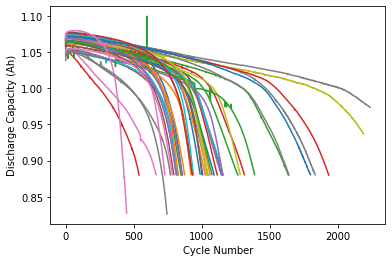

In [ ]:
for i in bat_dict.keys():
  plt.plot(bat_dict[i]['summary']['cycle'], bat_dict[i]['summary']['QD'])
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')

In [ ]:
bat_dict_keys = bat_dict.keys()

In [ ]:
bat_dict_keys

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b1c8', 'b1c10', 'b1c12', 'b1c13', 'b1c22', 'b1c46', 'b1c47'])

In [ ]:
RUL = []

for i in bat_dict_keys:
  
    cell = bat_dict[i]
    #len_summary_cycle = len(cell['summary']['cycle'])
    cycle_life = int(cell['summary']['cycle'][-1])
    for j in range(1,cycle_life):
        RUL.append(cycle_life-j)

In [ ]:
len(RUL)

52153

In [ ]:
def linear_interpolation(x, y, start, end, x_lin):
    x = x[start:end]
    y = y[start:end]
    f = interp1d(x,y)
    datalin = f(x_lin)
    datalin = smooth_curve(datalin)
    
    return(datalin)

In [ ]:
def smooth_curve(points, factor=0.6):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

In [ ]:
cycle_vector_features = (['Idlin', 
                          'Qdlin', 
                          'Tdlin', 
                          'dQdV'])

# Liste des features scalaires
cycle_scalar_features = (['IR', 
                          'Tavg', 
                          'Tmin', 
                          'Tmax', 
                          'QC', 
                          'QD', 
                          'SOH', 
                          'chargetime'])

# Définition des différentes matrices qui vont contenir les données d'entrainement

# matrice vectorielle 
cycle_vector_dataset_arr = np.zeros((len(RUL), len(cycle_vector_features), 200)) 
# matrice scalaire
cycle_scalar_dataset_arr = np.zeros((len(RUL), len(cycle_scalar_features))) 
# matrice commune vectorielle/scalaire
cycle_dataset_arr = (np.empty((len(RUL), 
                               len(cycle_vector_features)+len(cycle_scalar_features), 
                               200))) 
cycle_dataset_arr[:] = np.NaN


# Définition des différents dictionnaires qui vont contenir les données d'entrainement
cycle_vector_dataset_dict = {} #dictionnaire vectoriel
cycle_scalar_dataset_dict = {} #dictionnaire scalaire
global_dataset = {} # dictionnaire commun vectoriel/scalaire

s=0 # la variable s compte le nombre d'échantillons dans le dataset
for i in bat_dict_keys : # On parcourt toutes les cellules du dataset brut
    clear_output(wait=True)
    cell = bat_dict[i]   
    print('cell:', i) #affichage de la cellule de batterie en cours 
    cycle_life = len(cell['summary']['cycle'])
    
    for j in range(1,cycle_life): # on parcourt tous les cycles de la cellule 
        
        # récupération des données vectorielles 
        # on ne récupère que les données de décharge
        
        start_discharge = np.where(cell['cycles'][str(j)]['I'] < -0.05) # Début de la décharge
        start_discharge = start_discharge[0][0]
        
        end_discharge = np.where(cell['cycles'][str(j)]['I'] < -3.9) # Fin de la décharge
        end_discharge = end_discharge[0][-1]
        
        Vmin = min(cell['cycles'][str(j)]['V'][start_discharge:end_discharge]) 
        Vmax = max(cell['cycles'][str(j)]['V'][start_discharge:end_discharge])
        
        x_discharge = np.linspace(Vmax,Vmin,200) # Vecteur de référence à partir duquel 
                                                 # l'interpolation linéaire est réalisée
            
        # interpolation linéaire du courant, capacité de décharge et température   
        Idlin = linear_interpolation(cell['cycles'][str(j)]['V'], cell['cycles'][str(j)]['I'], \
                                     start_discharge, end_discharge, x_discharge)
        Qdlin = linear_interpolation(cell['cycles'][str(j)]['V'], cell['cycles'][str(j)]['Qd'], \
                                     start_discharge, end_discharge, x_discharge)
        Tdlin = linear_interpolation(cell['cycles'][str(j)]['V'], cell['cycles'][str(j)]['T'], \
                                     start_discharge, end_discharge, x_discharge)
        
        # interpolation linéaire de dQdV 
        g = interp1d(np.linspace(Vmax,Vmin,1000), cell['cycles'][str(j)]['dQdV'])
        dQdV = g(x_discharge)
        
        # Les vecteurs sont regroupés dans la matrice vectorielle
        cycle_vector_dataset_arr[s+j-1][0] = Idlin
        cycle_vector_dataset_arr[s+j-1][1] = Qdlin
        cycle_vector_dataset_arr[s+j-1][2] = Tdlin
        cycle_vector_dataset_arr[s+j-1][3] = dQdV
        
        # les vecteurs sont également regroupés dans la matrice globale
        cycle_dataset_arr[s+j-1][0] = Idlin
        cycle_dataset_arr[s+j-1][1] = Qdlin
        cycle_dataset_arr[s+j-1][2] = Tdlin
        cycle_dataset_arr[s+j-1][3] = dQdV
        
        # Un dictionnaire "échantillon" contenant uniquement 
        # les vecteurs de ce cycle est créé
        vector_sample_dict = ({'Idlin' : Idlin, 
                               'Qdlin' : Qdlin, 
                               'Tdlin' : Tdlin,
                               'dQdV'  : dQdV  }
                             )
        
        # Récupération des données scalaires
        IR = cell['summary']['IR'][j]
        Tavg = cell['summary']['Tavg'][j]
        Tmin = cell['summary']['Tmin'][j]
        Tmax = cell['summary']['Tmax'][j]
        QC = cell['summary']['QC'][j]
        QD = cell['summary']['QD'][j]
        chargetime = cell['summary']['chargetime'][j]
        SOH = (QD/cell['summary']['QD'][1])*100 
        
        # Les scalaires sont regroupés dans la matrice scalaire
        cycle_scalar_dataset_arr[s+j-1][0] = IR
        cycle_scalar_dataset_arr[s+j-1][1] = Tavg
        cycle_scalar_dataset_arr[s+j-1][2] = Tmin
        cycle_scalar_dataset_arr[s+j-1][3] = Tmax
        cycle_scalar_dataset_arr[s+j-1][4] = QC
        cycle_scalar_dataset_arr[s+j-1][5] = QD
        cycle_scalar_dataset_arr[s+j-1][6] = chargetime
        cycle_scalar_dataset_arr[s+j-1][7] = SOH
        
        # Les scalaires sont également ajoutés 
        # à la suite des vecteurs dans la matrice globale
        cycle_dataset_arr[s+j-1][4][0] = IR
        cycle_dataset_arr[s+j-1][5][0] = Tavg
        cycle_dataset_arr[s+j-1][6][0] = Tmin
        cycle_dataset_arr[s+j-1][7][0] = Tmax
        cycle_dataset_arr[s+j-1][8][0] = QC
        cycle_dataset_arr[s+j-1][9][0] = QD
        cycle_dataset_arr[s+j-1][10][0] = chargetime
        cycle_dataset_arr[s+j-1][11][0] = SOH
                
        # Un dictionnaire "échantillon" contenant uniquement 
        # les scalaires de ce cycle est créé
        scalar_sample_dict = ({'IR': IR , 
                               'Tavg': Tavg , 
                               'Tmin' : Tmin , 
                               'Tmax' : Tmax , 
                               'QC': QC, 
                               'QD':QD, 
                               'chargetime':chargetime, 
                               'SOH':SOH}
                             )
        
        # Les deux dictionnaires échantillons (vectoriel et scalaire) sont  
        # regroupés dans un dictionnaire échantillon global contenant 
        # à la fois les vecteurs et les scalaires de ce cycle
        global_sample_dict = {**vector_sample_dict, **scalar_sample_dict}
    
        # Attribution d'un intitulé à chaque échantillon
        dict_key = "{}_cycle_{}".format(i,j) 
        
        # Le dictionnaire échantillon vectoriel est ajouté au dictionnaire vectoriel
        # contenant les vecteurs de tous les cycles
        cycle_scalar_dataset_dict[dict_key] = scalar_sample_dict
        
        # Le dictionnaire échantillon scalaire est ajouté au dictionnaire scalaire
        # contenant les scalaires de tous les cycles
        cycle_vector_dataset_dict[dict_key] = vector_sample_dict
        
        # Le dictionnaire échantillon global est ajouté au dictionnaire global 
        # contenant les vecteurs et les scalaires de chaque cycle
        global_dataset[dict_key] = global_sample_dict
        
    s+=j # s représente le numéro de l'échantillon créé 
print('all cycles from batches 1, 2 and 3 were browsed')

cell: b1c47
all cycles from batches 1, 2 and 3 were browsed


In [ ]:
cycle_vector_dataset_df = pd.DataFrame(cycle_vector_dataset_dict)

# Création d'un dataframe scalaire
cycle_scalar_dataset_df = pd.DataFrame(cycle_scalar_dataset_dict)

#Création d'un dataframe global
cycle_dataset_df = pd.DataFrame(global_dataset)

In [ ]:
cycle_dataset_df


,b1c0_cycle_1,b1c0_cycle_2,b1c0_cycle_3,b1c0_cycle_4,b1c0_cycle_5,b1c0_cycle_6,b1c0_cycle_7,b1c0_cycle_8,b1c0_cycle_9,b1c0_cycle_10,...,b1c47_cycle_735,b1c47_cycle_736,b1c47_cycle_737,b1c47_cycle_738,b1c47_cycle_739,b1c47_cycle_740,b1c47_cycle_741,b1c47_cycle_742,b1c47_cycle_743,b1c47_cycle_744
Idlin,"[-0.560043509090909, -0.6968178407725167, -0.9...","[-0.5200932272727272, -0.6591509167191169, -0....","[-0.5199423727272726, -0.6578318908908884, -0....","[-0.5999712545454545, -0.7368716804921043, -0....","[-0.5998438090909091, -0.7365053004657165, -0....","[-0.6000995636363636, -0.739821696962288, -0.9...","[-0.4799444, -0.624206668715477, -0.8462405869...","[-0.5996556727272727, -0.7388988143431376, -0....","[-0.5199475727272728, -0.6596524905155831, -0....","[-0.5598857181818182, -0.6992990799571797, -0....",...,"[-0.4394722, -0.5600132847924018, -0.747594117...","[-0.4399039545454545, -0.560833018440097, -0.7...","[-0.44002272727272723, -0.5611238890610376, -0...","[-0.4000932545454545, -0.522952596107014, -0.7...","[-0.3996883727272727, -0.522714353169983, -0.7...","[-0.43852199090909083, -0.5572443836420431, -0...","[-0.43979210909090904, -0.5521015207414934, -0...","[-0.40040622727272723, -0.5202735743349837, -0...","[-0.40016608181818175, -0.5191046374039734, -0...","[-0.40032993636363634, -0.5232802077076555, -0..."
Qdlin,"[9.0033354e-06, 9.0033354e-06, 9.0033354e-06, ...","[4.4997469e-06, 4.4997469e-06, 4.4997469e-06, ...","[5.4048696e-06, 5.4048696e-06, 8.5953235332171...","[7.4323725e-06, 7.4323725e-06, 7.4323725e-06, ...","[7.7532759e-06, 7.7532759e-06, 7.7532759e-06, ...","[4.1716985e-06, 4.1716985e-06, 4.1716985e-06, ...","[6.8169729e-06, 6.816972899999999e-06, 6.81697...","[6.1982837e-06, 6.1982837e-06, 6.1982837e-06, ...","[6.7026822e-06, 6.7026822e-06, 6.7026822e-06, ...","[8.3895693e-06, 8.3895693e-06, 8.3895693e-06, ...",...,"[4.2034671e-06, 4.2034671e-06, 1.0388625852373...","[4.4097774e-06, 4.4097774e-06, 4.4097774e-06, ...","[4.4317703e-06, 4.4317703e-06, 4.4317703e-06, ...","[3.2687278e-06, 3.2687278e-06, 3.2687278e-06, ...","[3.6265888e-06, 3.6265888e-06, 3.6265888e-06, ...","[4.2054021e-06, 4.2054021e-06, 4.2054021e-06, ...","[4.2301972e-06, 4.2301972e-06, 4.2301972e-06, ...","[3.676628e-06, 3.676628e-06, 9.037884410532407...","[3.6277388e-06, 3.6277388e-06, 3.6277388e-06, ...","[3.4956697e-06, 3.4956697e-06, 3.4956697e-06, ..."
Tdlin,"[30.820534457644424, 30.819985683275526, 30.81...","[30.852327120486237, 30.85247012513102, 30.852...","[30.832358788433, 30.832283175016975, 30.83216...","[30.830612178178495, 30.830403755313593, 30.83...","[30.71032588378695, 30.710494819446023, 30.710...","[30.74225472322275, 30.74238995389081, 30.7426...","[30.773305896811685, 30.77354525152012, 30.773...","[30.777844409037773, 30.777785740594624, 30.77...","[30.90306218005518, 30.903031343368127, 30.902...","[30.995105817599928, 30.995122652272094, 30.99...",...,"[29.878868, 29.883811950126177, 29.88842157007...","[30.035067, 30.035067000000005, 30.03506700000...","[29.984766, 29.984766, 29.984766, 29.984766, 2...","[29.948359, 29.948359, 29.948359, 29.948359, 2...","[29.859871, 29.859871, 29.859871, 29.859871, 2...","[29.94058, 29.940580000000004, 29.940580000000...","[29.941271, 29.941271, 29.941271, 29.941271, 2...","[29.837681, 29.837681000000003, 29.83768100000...","[29.817024, 29.817023999999996, 29.81702399999...","[29.84683, 29.84683, 29.84683, 29.84683, 29.84..."
dQdV,"[0.0, -0.0038980357786781374, -0.0276160877263...","[0.0, 0.0, 0.0, -0.0012117839117345391, -0.030...","[-0.003899322558070411, -0.0038993225580704113...","[0.0, -0.005296338862016056, -0.03275976867477...","[0.0, 0.0, 0.0, -4.487744349151491e-05, -0.019...","[0.0, -0.0024907694423430427, -0.0276330917618...","[-0.01568066679124452, -0.01568066679124452, -...","[-0.02035724463210379, -0.02035724463210379, -...","[-0.012252776983516575, -0.012252776983516577,...","[0.0, 0.0, -0.0007758510420292511, -0.02299630...",...,"[-0.0029026259887782453,

In [ ]:
cycle_dataset_df.to_csv("battery_dataset.csv")

In [ ]:
cycle_dataset_df=pd.read_csv("/content/drive/MyDrive/battery_dataset.csv",index_col=False)


In [ ]:
cycle_dataset_df

,Unnamed: 0,b1c0_cycle_1,b1c0_cycle_2,b1c0_cycle_3,b1c0_cycle_4,b1c0_cycle_5,b1c0_cycle_6,b1c0_cycle_7,b1c0_cycle_8,b1c0_cycle_9,...,b1c47_cycle_735,b1c47_cycle_736,b1c47_cycle_737,b1c47_cycle_738,b1c47_cycle_739,b1c47_cycle_740,b1c47_cycle_741,b1c47_cycle_742,b1c47_cycle_743,b1c47_cycle_744
0,IR,0.455424,0.452761,0.449668,0.448281,0.447754,0.446501,0.445052,0.444763,0.443617,...,0.827092,0.826428,0.835673,0.838127,0.836679,0.842594,0.842450,0.849420,0.852226,0.854338
1,Tavg,0.105770,0.104036,0.103825,0.099499,0.096915,0.100106,0.102325,0.103374,0.102859,...,0.216543,0.228346,0.225308,0.229406,0.223161,0.225051,0.212827,0.218413,0.227116,0.229457
2,Tmin,0.317322,0.322496,0.320163,0.318695,0.307087,0.312029,0.312549,0.315030,0.309406,...,0.212062,0.227877,0.217279,0.219081,0.204950,0.215950,0.218427,0.205695,0.202360,0.205690
3,Tmax,0.163124,0.157275,0.155709,0.152215,0.155025,0.155891,0.160206,0.160290,0.178347,...,0.525517,0.519817,0.522608,0.527419,0.539784,0.520675,0.523620,0.529785,0.525529,0.531802
4,QC,0.868790,0.871148,0.873157,0.875093,0.876001,0.877629,0.878094,0.879494,0.879919,...,0.064349,0.058293,0.050938,0.044119,0.036677,0.030075,0.023297,0.015471,0.008111,0.000000
5,QD,0.881763,0.884796,0.886344,0.887752,0.888926,0.890079,0.891018,0.891930,0.892596,...,0.065704,0.057545,0.051726,0.044829,0.037311,0.030270,0.021702,0.015701,0.007836,0.000000
6,chargetime,0.000990,0.000946,0.001439,0.000948,0.000930,0.000900,0.000940,0.001026,0.000954,...,0.476268,0.476268,0.476268,0.476268,0.476268,0.476268,0.476268,0.476268,0.476268,0.476268
7,SOH,0.818220,0.820999,0.822417,0.823707,0.824783,0.825840,0.826700,0.827536,0.828146,...,0.139198,0.131540,0.126079,0.119606,0.112550,0.105943,0.097901,0.092270,0.084889,0.077535


In [ ]:
data=cycle_dataset_df.T
data

,0,1,2,3,4,5,6,7
Unnamed: 0,IR,Tavg,Tmin,Tmax,QC,QD,chargetime,SOH
b1c0_cycle_1,0.455424,0.10577,0.317322,0.163124,0.86879,0.881763,0.00099,0.81822
b1c0_cycle_2,0.452761,0.104036,0.322496,0.157275,0.871148,0.884796,0.000946,0.820999
b1c0_cycle_3,0.449668,0.103825,0.320163,0.155709,0.873157,0.886344,0.001439,0.822417
b1c0_cycle_4,0.448281,0.099499,0.318695,0.152215,0.875093,0.887752,0.000948,0.823707
...,...,...,...,...,...,...,...,...
b1c47_cycle_740,0.842594,0.225051,0.21595,0.520675,0.030075,0.03027,0.476268,0.105943
b1c47_cycle_741,0.84245,0.212827,0.218427,0.52362,0.023297,0.021702,0.476268,0.097901
b1c47_cycle_742,0.84942,0.218413,0.205695,0.529785,0.015471,0.015701,0.476268,0.09227
b1c47_cycle_743,0.852226,0.227116,0.20236,0.525529,0.008111,0.007836,0.476268,0.084889


In [ ]:
data=data.rename(columns={0:"IR",1:"Tavg",2:"Tmin",3:"Tmax",4:"QC",5:"QD",6:"chargetime",7:"SOH"})

In [ ]:
data=data.drop("Unnamed: 0")

In [ ]:
cycle_dataset_df=data.T

In [ ]:
cycle_dataset_df

,b1c0_cycle_1,b1c0_cycle_2,b1c0_cycle_3,b1c0_cycle_4,b1c0_cycle_5,b1c0_cycle_6,b1c0_cycle_7,b1c0_cycle_8,b1c0_cycle_9,b1c0_cycle_10,...,b1c47_cycle_735,b1c47_cycle_736,b1c47_cycle_737,b1c47_cycle_738,b1c47_cycle_739,b1c47_cycle_740,b1c47_cycle_741,b1c47_cycle_742,b1c47_cycle_743,b1c47_cycle_744
IR,0.455424,0.452761,0.449668,0.448281,0.447754,0.446501,0.445052,0.444763,0.443617,0.443293,...,0.827092,0.826428,0.835673,0.838127,0.836679,0.842594,0.84245,0.84942,0.852226,0.854338
Tavg,0.10577,0.104036,0.103825,0.099499,0.096915,0.100106,0.102325,0.103374,0.102859,0.100636,...,0.216543,0.228346,0.225308,0.229406,0.223161,0.225051,0.212827,0.218413,0.227116,0.229457
Tmin,0.317322,0.322496,0.320163,0.318695,0.307087,0.312029,0.312549,0.31503,0.309406,0.339754,...,0.212062,0.227877,0.217279,0.219081,0.20495,0.21595,0.218427,0.205695,0.20236,0.20569
Tmax,0.163124,0.157275,0.155709,0.152215,0.155025,0.155891,0.160206,0.16029,0.178347,0.153605,...,0.525517,0.519817,0.522608,0.527419,0.539784,0.520675,0.52362,0.529785,0.525529,0.531802
QC,0.86879,0.871148,0.873157,0.875093,0.876001,0.877629,0.878094,0.879494,0.879919,0.879992,...,0.064349,0.058293,0.050938,0.044119,0.036677,0.030075,0.023297,0.015471,0.008111,0.0
QD,0.881763,0.884796,0.886344,0.887752,0.888926,0.890079,0.891018,0.89193,0.892596,0.892681,...,0.065704,0.057545,0.051726,0.044829,0.037311,0.03027,0.021702,0.015701,0.007836,0.0
chargetime,0.00099,0.000946,0.001439,0.000948,0.00093,0.0009,0.00094,0.001026,0.000954,0.001005,...,0.476268,0.476268,0.476268,0.476268,0.476268,0.476268,0.476268,0.476268,0.476268,0.476268
SOH,0.81822,0.820999,0.822417,0.823707,0.824783,0.82584,0.8267,0.827536,0.828146,0.828224,...,0.139198,0.13154,0.126079,0.119606,0.11255,0.105943,0.097901,0.09227,0.084889,0.077535


**Normalization of the data (min max )**

In [ ]:
import math as m
mn_IR=min(data.IR)
mx_IR=max(data.IR)
m=mx_IR -mn_IR
data.IR=data.IR.apply(lambda x:(x-mn_IR)/m)
mn_Tavg=min(data.Tavg)
mx_Tavg=max(data.Tavg)
m=mx_Tavg -mn_Tavg
data.Tavg=data.Tavg.apply(lambda x:(x-mn_Tavg)/m)
mn_Tmin=min(data.Tmin)
mx_Tmin=max(data.Tmin)
m=mx_Tmin -mn_Tmin
data.Tmin=data.Tmin.apply(lambda x:(x-mn_Tmin)/m)
mn_Tmax=min(data.Tmax)
mx_Tmax=max(data.Tmax)
m=mx_Tmax -mn_Tmax
data.Tmax=data.Tmax.apply(lambda x:(x-mn_Tmax)/m)
mn_QC=min(data.QC)
mx_QC=max(data.QC)
m=mx_QC -mn_QC
data.QC=data.QC.apply(lambda x:(x-mn_QC)/m)
mn_QD=min(data.QD)
mx_QD=max(data.QD)
m=mx_QD -mn_QD
data.QD=data.QD.apply(lambda x:(x-mn_QD)/m)
mn_chargetime=min(data.chargetime)
mx_chargetime=max(data.chargetime)
m=mx_chargetime -mn_chargetime
data.chargetime=data.chargetime.apply(lambda x:(x-mn_chargetime)/m)
mn_SOH=min(data.SOH)
mx_SOH=max(data.SOH)
m=mx_SOH -mn_SOH
data.SOH=data.SOH.apply(lambda x:(x-mn_SOH)/m)

**splitting the data by cell**

In [ ]:

cells=[]
for i in range(48):
  filter_col = [col for col in cycle_dataset_df if col.startswith('b1c'+str(i))]
  data=cycle_dataset_df[filter_col].T
  data=data.reset_index(drop=True)
  cells.append(data)


In [ ]:
len(cells)

48

In [ ]:
train_size=int(0.6*48)
train_data=cells[0:train_size]
test_data=cells[train_size:46]

In [ ]:
len(train_data)

28

In [ ]:
train_data[0][0:1]["SOH"]

0    0.81822
Name: SOH, dtype: object

**For each cell we will get The inputs and the outputs for our model **

In [ ]:
# split a univariate sequence into samples
def split_sequence(X,y,sequence, n_steps_in, n_steps_out):
 
   for i in range(len(sequence)):
       # find the end of this pattern
       end_ix = i + n_steps_in
       out_end_ix = end_ix + n_steps_out
 # check if we are beyond the sequence
       if out_end_ix > len(sequence):
              break
 # gather input and output parts of the pattern
       seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
       X.append(seq_x)
       y.append(seq_y["SOH"])
   return X, y

Split the data into train and test

In [ ]:
X_train=[]
Y_train=[]
X_test=[]
Y_test=[]
for i in range(len(train_data)):
  X_train,Y_train=split_sequence(X_train,Y_train,train_data[i],10,1)
for i in range(len(test_data)):
  X_test,Y_test=split_sequence(X_test,Y_test,test_data[i],10,1)
  



In [ ]:
size1=len(X_train)
size2=len(X_test)
X1=np.zeros((size1,10,8))
Y1=np.zeros((size1))
for i in range(size1):
   X1[i]=X_train[i]
   Y1[i]=Y_train[i]
X2=np.zeros((size2,10,8))
Y2=np.zeros((size2))
for i in range(size2):
   X2[i]=X_test[i]
   Y2[i]=Y_test[i]



In [ ]:
X1.shape

(70937, 10, 8)

In [ ]:
np.shape(X1[0])

(10, 8)

In [ ]:
Y1.shape

(70937,)

In [ ]:
def createModel(num_steps,inputShape,output):
# define model
     model = Sequential()
     model.add(LSTM(32, input_shape=(num_steps, inputShape)))
     model.add(Dense(output))
     model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mse'])
     return model

In [ ]:
model=createModel(X1.shape[1],X1.shape[2],1)

In [ ]:
model.fit(X1, Y1, epochs=10, verbose=1,batch_size=64,validation_data=(X2,Y2))

Epoch 1/10
1109/1109 [==============================] - 14s 6ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 3.3550e-04 - val_mse: 3.3550e-04
Epoch 2/10
1109/1109 [==============================] - 6s 5ms/step - loss: 5.1714e-04 - mse: 5.1714e-04 - val_loss: 9.9138e-05 - val_mse: 9.9138e-05
Epoch 3/10
1109/1109 [==============================] - 7s 6ms/step - loss: 3.0760e-04 - mse: 3.0760e-04 - val_loss: 3.1288e-05 - val_mse: 3.1288e-05
Epoch 4/10
1109/1109 [==============================] - 6s 5ms/step - loss: 2.7033e-04 - mse: 2.7033e-04 - val_loss: 1.6998e-05 - val_mse: 1.6998e-05
Epoch 5/10
1109/1109 [==============================] - 7s 6ms/step - loss: 2.4846e-04 - mse: 2.4846e-04 - val_loss: 1.5234e-05 - val_mse: 1.5234e-05
Epoch 6/10
1109/1109 [==============================] - 7s 6ms/step - loss: 2.3847e-04 - mse: 2.3847e-04 - val_loss: 1.4383e-05 - val_mse: 1.4383e-05
Epoch 7/10
1109/1109 [==============================] - 7s 6ms/step - loss: 2.2033e-04 - mse: 2.2033e-04 - 

In [ ]:
ypredict=model.predict(X2[0:1])
(ypredict[0][0]*(mx_SOH-mn_SOH))+mn_SOH

1/1 [==============================] - 0s 352ms/step


0.8181741237640381

In [ ]:
(Y2[0]*(mx_SOH-mn_SOH))+mn_SOH

0.8191629301070177

In [ ]:
explainer = shap.DeepExplainer(model,X2[0:50])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [ ]:
np.shape(X2[0:1])

(1, 10, 8)

In [ ]:
shap_values = explainer.shap_values(X2[0:1])

In [ ]:
shap.initjs() 

In [ ]:
inputs = tf.constant(X1)
with tf.GradientTape() as tape:
    tape.watch(inputs)
    outputs = model(inputs)
grads = (tape.gradient(outputs, inputs))
grads_numpy = tf.keras.backend.eval(grads)

# Calculate the feature importance scores
importance_scores = np.mean(np.abs(grads_numpy), axis=0)

# Print the feature importance scores
print(importance_scores)

[[0.00117342 0.00408302 0.00156863 0.00546244 0.01449748 0.00928071
  0.03058889 0.01294591]
 [0.00095736 0.00410704 0.00186878 0.00503758 0.01971209 0.01180339
  0.0370603  0.01882725]
 [0.00140169 0.00431291 0.00159506 0.00398643 0.02623146 0.01520362
  0.04275433 0.02716484]
 [0.00213524 0.00463336 0.00105635 0.00226672 0.03340927 0.01907616
  0.0459002  0.0391148 ]
 [0.00264173 0.0047657  0.0014823  0.00052069 0.04004975 0.02274518
  0.04341142 0.05607055]
 [0.00291894 0.00411454 0.0041562  0.00228904 0.04391681 0.02500616
  0.03067358 0.07951182]
 [0.00280876 0.00197961 0.00767416 0.0038694  0.04092356 0.02362301
  0.00551633 0.11056679]
 [0.00225001 0.00304233 0.0110929  0.00362446 0.02439076 0.01466978
  0.0478478  0.14891455]
 [0.00671152 0.01004131 0.00839758 0.00466222 0.01484625 0.01277767
  0.11706565 0.19256887]
 [0.00870623 0.03436838 0.02567939 0.01145172 0.17477965 0.17619273
  0.05838165 0.27943995]]


SHap values plot  indicats that SOH has the most important impact on the 
output and that what MISS Ines told me about yesterday

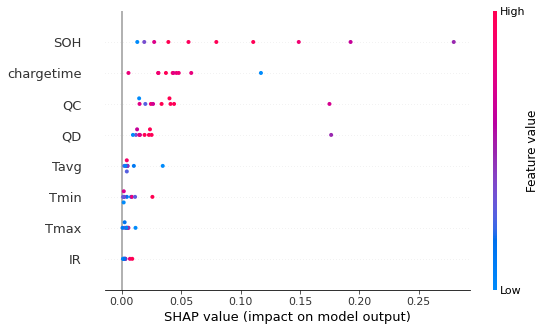

In [ ]:
shap.summary_plot(importance_scores, X2[0:1][0],feature_names=["IR"	,"Tavg"	,"Tmin"	,"Tmax"	,"QC"	,"QD"	,"chargetime",	"SOH"])

Now I will try to build a model but in this case I will not take The SOH as input

In [ ]:
# split a univariate sequence into samples
def split_sequence2(X,y,sequence, n_steps_in, n_steps_out):
 
   for i in range(len(sequence)):
       # find the end of this pattern
       end_ix = i + n_steps_in
       out_end_ix = end_ix + n_steps_out
 # check if we are beyond the sequence
       if out_end_ix > len(sequence):
              break
 # gather input and output parts of the pattern
       seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
       X.append(seq_x.drop("SOH",axis=1))
       y.append(seq_y["SOH"])
   return X, y

In [ ]:
train_size=int(0.6*46)
train_data=cells[0:train_size]
test_data=cells[train_size:46]

In [ ]:
X_train=[]
Y_train=[]
X_test=[]
Y_test=[]
for i in range(len(train_data)):
  X_train,Y_train=split_sequence2(X_train,Y_train,train_data[i],10,1)
for i in range(len(test_data)):
  X_test,Y_test=split_sequence2(X_test,Y_test,test_data[i],10,1)

In [ ]:
size1=len(X_train)
size2=len(X_test)
X1=np.zeros((size1,10,7))
Y1=np.zeros((size1))
for i in range(size1):
   X1[i]=X_train[i]
   Y1[i]=Y_train[i]
X2=np.zeros((size2,10,7))
Y2=np.zeros((size2))
for i in range(size2):
   X2[i]=X_test[i]
   Y2[i]=Y_test[i]


In [ ]:
model2=createModel(X1.shape[1],X1.shape[2],1)

In [ ]:
model2.fit(X1, Y1, epochs=10, verbose=1,batch_size=64,validation_data=(X2,Y2))

Epoch 1/10
1096/1096 [==============================] - 9s 7ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 8.1499e-04 - val_mse: 8.1499e-04
Epoch 2/10
1096/1096 [==============================] - 6s 5ms/step - loss: 9.2011e-04 - mse: 9.2011e-04 - val_loss: 6.9002e-04 - val_mse: 6.9002e-04
Epoch 3/10
1096/1096 [==============================] - 6s 6ms/step - loss: 8.1472e-04 - mse: 8.1472e-04 - val_loss: 6.9187e-04 - val_mse: 6.9187e-04
Epoch 4/10
1096/1096 [==============================] - 6s 5ms/step - loss: 7.7193e-04 - mse: 7.7193e-04 - val_loss: 6.3189e-04 - val_mse: 6.3189e-04
Epoch 5/10
1096/1096 [==============================] - 7s 6ms/step - loss: 7.3382e-04 - mse: 7.3382e-04 - val_loss: 6.2381e-04 - val_mse: 6.2381e-04
Epoch 6/10
1096/1096 [==============================] - 5s 5ms/step - loss: 7.0318e-04 - mse: 7.0318e-04 - val_loss: 5.5553e-04 - val_mse: 5.5553e-04
Epoch 7/10
1096/1096 [==============================] - 6s 6ms/step - loss: 6.8623e-04 - mse: 6.8623e-04 - v

In [ ]:
ypredict=model2.predict(X2[0:1])
(ypredict[0][0]*(mx_SOH-mn_SOH))+mn_SOH

1/1 [==============================] - 0s 338ms/step


0.8107518553733826

In [ ]:
(Y2[0]*(mx_SOH-mn_SOH))+mn_SOH

0.8299867144904574

In [ ]:
explainer2 = shap.DeepExplainer(model2,X2[0:50])

In [ ]:
inputs = tf.constant(X1)
with tf.GradientTape() as tape:
    tape.watch(inputs)
    outputs = model2(inputs)
grads = (tape.gradient(outputs, inputs))
grads_numpy = tf.keras.backend.eval(grads)

# Calculate the feature importance scores
importance_scores = np.mean(np.abs(grads_numpy), axis=0)

# Print the feature importance scores
print(importance_scores)

[[0.00941085 0.02408577 0.01307797 0.01609765 0.00689673 0.00812307
  0.00966477]
 [0.00978309 0.02310215 0.01231497 0.01484229 0.00632156 0.00852116
  0.01244919]
 [0.00992733 0.02124244 0.01126942 0.01338406 0.00578366 0.00836317
  0.01557977]
 [0.0102645  0.01907702 0.01003715 0.01185639 0.00522037 0.00794475
  0.01847664]
 [0.01151488 0.0168606  0.00877931 0.01031815 0.00495177 0.00725389
  0.02026497]
 [0.01396927 0.01478354 0.00787997 0.00880791 0.00616661 0.00622395
  0.01971302]
 [0.01601748 0.01323012 0.0075705  0.00744154 0.01196574 0.00936216
  0.0167342 ]
 [0.01318021 0.01328125 0.00720106 0.00627168 0.03030972 0.03087995
  0.02045469]
 [0.01306901 0.01666823 0.01462611 0.00521435 0.07257051 0.07616658
  0.06069404]
 [0.13543076 0.0118593  0.04438921 0.04580541 0.28433713 0.29645318
  0.04294719]]


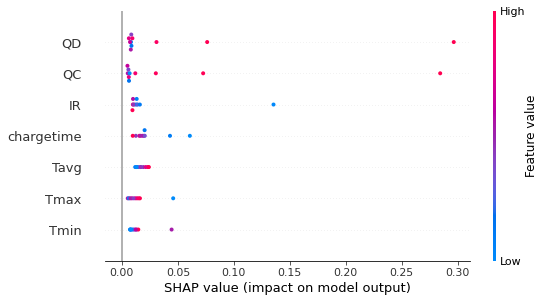

In [ ]:
shap.summary_plot(importance_scores, X2[0:1][0],feature_names=["IR"	,"Tavg"	,"Tmin"	,"Tmax"	,"QC"	,"QD"	,"chargetime"])

In [ ]:
k = 3
top_features = np.argsort(-np.abs(importance_scores), axis=1)[:, :k]

In [ ]:
feature_names=["IR"	,"Tavg"	,"Tmin"	,"Tmax"	,"QC"	,"QD"	,"chargetime"]
top_features

array([[6, 5, 3],
       [6, 5, 3],
       [6, 5, 4],
       [6, 5, 4],
       [6, 5, 4],
       [6, 5, 4],
       [5, 6, 4],
       [5, 6, 4],
       [5, 4, 6],
       [5, 4, 6]])

In [ ]:
event_mapping = {
    '0': 'IR',
    '1': 'TAVG',
    '2': 'TMIN',
    '3': 'TMAX',
    '4': 'QC',
    '5':"QD",
    '6':"CHARGETIME"
}

from collections import defaultdict
chronicles = defaultdict(list)
for i in range(len(importance_scores)):
    for j in range(k):
        feature = top_features[i, j]
        event = event_mapping[str(feature)]
        chronicles[i].append(event)

# Print the first 10 chronicles
for i in range(10):
    print(f"Chronicle {i}: {' -> '.join(chronicles[i])}")

Chronicle 0: CHARGETIME -> QD -> TMAX
Chronicle 1: CHARGETIME -> QD -> TMAX
Chronicle 2: CHARGETIME -> QD -> QC
Chronicle 3: CHARGETIME -> QD -> QC
Chronicle 4: CHARGETIME -> QD -> QC
Chronicle 5: CHARGETIME -> QD -> QC
Chronicle 6: QD -> CHARGETIME -> QC
Chronicle 7: QD -> CHARGETIME -> QC
Chronicle 8: QD -> QC -> CHARGETIME
Chronicle 9: QD -> QC -> CHARGETIME


In [ ]:
!pip install pychronicles

In [ ]:
chronicles[0]

['CHARGETIME', 'QD', 'TMAX']

In [ ]:
!pip install multiset
import multiset
from pychronicles import Chronicle,TimedSequence

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
c=Chronicle()
# create a timed sequence
seq=[]
j=0
for i in chronicles:
   seq.append((chronicles[i],j))
   j=j+1
ts = TimedSequence(np.array([e[1] for e in seq], dtype='float'), [e[0] for e in seq])


In [ ]:
print(ts)

0.0:['CHARGETIME' 'QD' 'TMAX']
1.0:['CHARGETIME' 'QD' 'TMAX']
2.0:['CHARGETIME' 'QD' 'QC']
3.0:['CHARGETIME' 'QD' 'QC']
4.0:['CHARGETIME' 'QD' 'QC']
5.0:['CHARGETIME' 'QD' 'QC']
6.0:['QD' 'CHARGETIME' 'QC']
7.0:['QD' 'CHARGETIME' 'QC']
8.0:['QD' 'QC' 'CHARGETIME']
9.0:['QD' 'QC' 'CHARGETIME']


In [ ]:
c.add_event(0,"CHARGETIME")